In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, roc_auc_score, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from sklearn.base import clone
from sklearn.manifold import TSNE
import shap
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Data load and quick pre-processing
df = pd.read_csv("/content/heart_2020_cleaned.csv")

binary_cols = df.columns[df.isin(['Yes', 'No']).any()]
df[binary_cols] = df[binary_cols].replace({'Yes': 1, 'No': 0})
df['Diabetic'] = df['Diabetic'].replace({'No': 0, 'Yes': 1, 'No, borderline diabetes': 0.5, 'Yes (during pregnancy)': 0.75})
df['GenHealth'] = df['GenHealth'].map({'Poor': 0, 'Fair': 1, 'Good': 2, 'Very good': 3, 'Excellent': 4})
df['AgeCategory'] = df['AgeCategory'].map({
    '18-24': 0, '25-29': 1, '30-34': 2, '35-39': 3, '40-44': 4, '45-49': 5,
    '50-54': 6, '55-59': 7, '60-64': 8, '65-69': 9, '70-74': 10, '75-79': 11, '80 or older': 12
})
df = pd.get_dummies(df, columns=['Sex', 'Race'], drop_first=True)
df = df.drop_duplicates()

In [3]:
# Splitting and scaling the data
X = df.drop(columns='Smoking')
y = df['Smoking']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Best RF AUC (CV): 0.6772376179235831


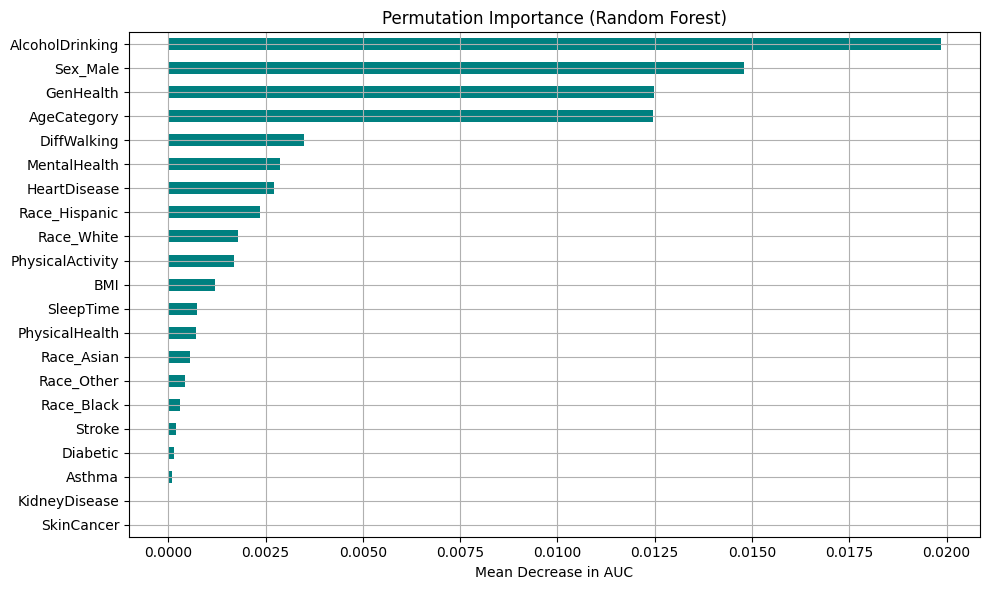

In [5]:
# Random Forest

# Grid search
rf_params = {'n_estimators': [100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=StratifiedKFold(5), scoring='roc_auc')
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
print("Best RF AUC (CV):", grid_rf.best_score_)


# Permutation importance
perm = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_importances = pd.Series(perm.importances_mean, index=X.columns)

plt.figure(figsize=(10,6))
perm_importances.sort_values().plot.barh(color='teal')
plt.title("Permutation Importance (Random Forest)")
plt.xlabel("Mean Decrease in AUC")
plt.grid(True)
plt.tight_layout()
plt.show()

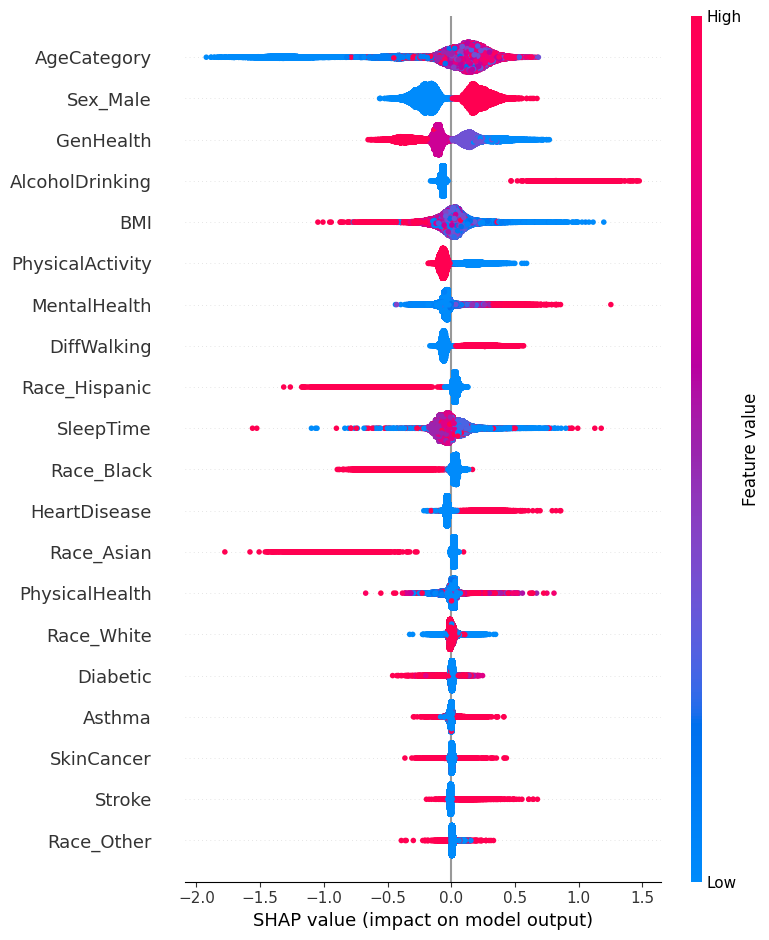

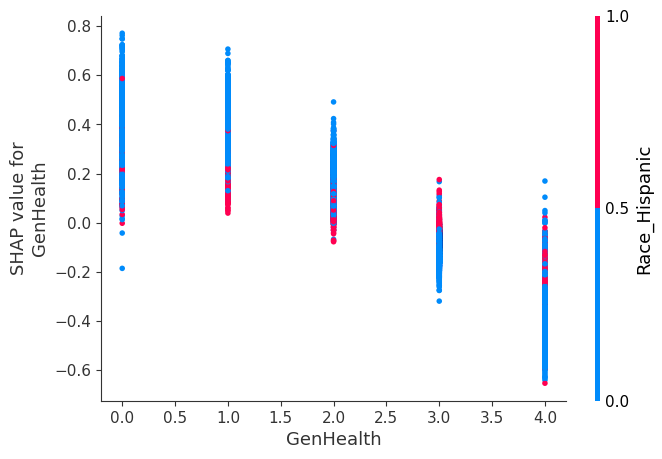

In [6]:
# SHAP Values (XGBoost)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_scaled, y_train)
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, features=X_test, feature_names=X.columns)
shap.dependence_plot("GenHealth", shap_values.values, X_test)


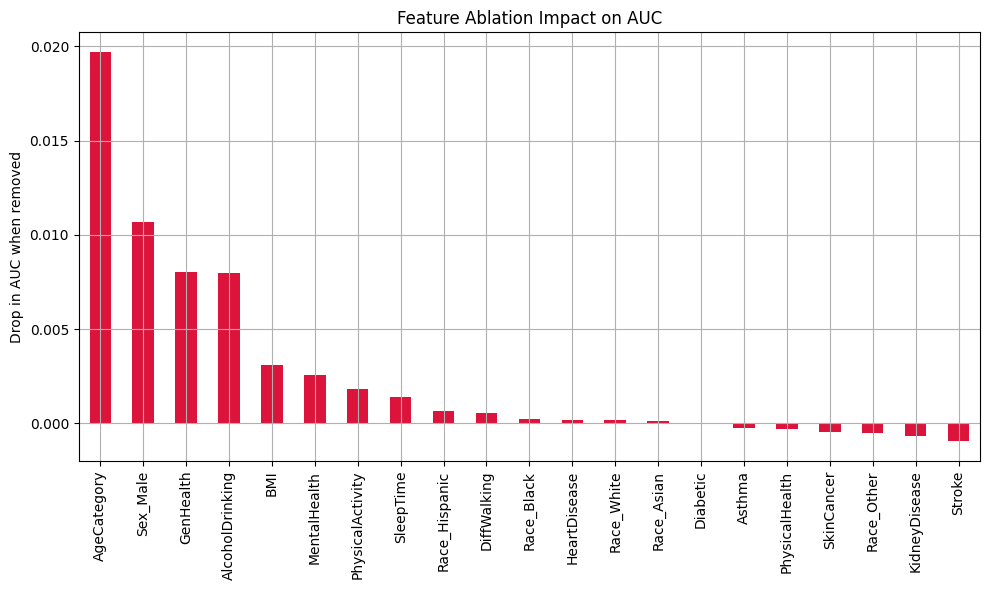

In [9]:
# Feature Ablation Study

def ablation_study(model, X, y, features):
    base_auc = roc_auc_score(y, model.fit(scaler.fit_transform(X), y).predict_proba(scaler.transform(X))[:,1])
    drop_results = {}
    for col in features:
        X_drop = X.drop(columns=[col])
        model_clone = clone(model)
        auc_score = roc_auc_score(
            y, model_clone.fit(scaler.fit_transform(X_drop), y).predict_proba(scaler.transform(X_drop))[:,1]
        )
        drop_results[col] = base_auc - auc_score
    return pd.Series(drop_results).sort_values(ascending=False)

ablation_scores = ablation_study(best_rf, X_train, y_train, X_train.columns)

plt.figure(figsize=(10, 6))
ablation_scores.plot.bar(color='crimson')
plt.title("Feature Ablation Impact on AUC")
plt.ylabel("Drop in AUC when removed")
plt.grid(True)
plt.tight_layout()
plt.show()


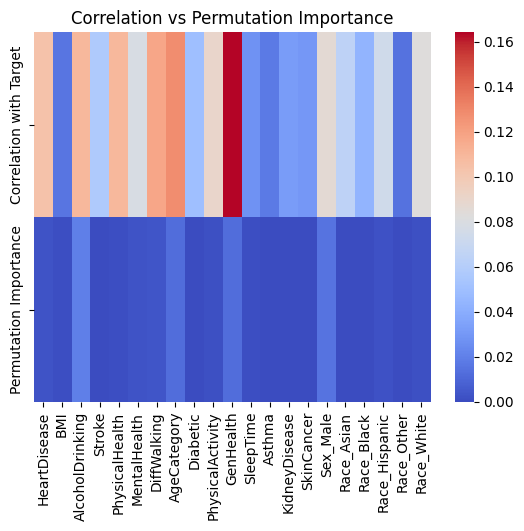

In [10]:
# Correlation vs. Permutation Importance

correlations = pd.Series([
    abs(np.corrcoef(X_train[col], y_train)[0, 1]) for col in X_train.columns
], index=X_train.columns)

compare_df = pd.DataFrame({
    'Correlation with Target': correlations,
    'Permutation Importance': perm_importances
})

sns.heatmap(compare_df.T, annot=False, cmap='coolwarm')
plt.title("Correlation vs Permutation Importance")
plt.show()


In [11]:
# Random masking and building the NN

def random_mask(X, mask_prob=0.1):
    X_masked = X.copy()
    mask = np.random.rand(*X.shape) < mask_prob
    X_masked[mask] = 0
    return X_masked

X_train_tensor = torch.tensor(random_mask(X_train_scaled), dtype=torch.float32)
X_test_tensor = torch.tensor(random_mask(X_test_scaled), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

# Multi-Layer Perceptron
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = MLP(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

for epoch in range(25):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {epoch_loss / len(train_loader):.4f}")


Epoch 1: Loss = 0.6419
Epoch 2: Loss = 0.6376
Epoch 3: Loss = 0.6361
Epoch 4: Loss = 0.6353
Epoch 5: Loss = 0.6349
Epoch 6: Loss = 0.6340
Epoch 7: Loss = 0.6338
Epoch 8: Loss = 0.6337
Epoch 9: Loss = 0.6333
Epoch 10: Loss = 0.6331
Epoch 11: Loss = 0.6327
Epoch 12: Loss = 0.6328
Epoch 13: Loss = 0.6325
Epoch 14: Loss = 0.6322
Epoch 15: Loss = 0.6323
Epoch 16: Loss = 0.6320
Epoch 17: Loss = 0.6317
Epoch 18: Loss = 0.6320
Epoch 19: Loss = 0.6318
Epoch 20: Loss = 0.6319
Epoch 21: Loss = 0.6316
Epoch 22: Loss = 0.6314
Epoch 23: Loss = 0.6317
Epoch 24: Loss = 0.6315
Epoch 25: Loss = 0.6313


In [12]:
# Evaluation of the NN

model.eval()
with torch.no_grad():
    probs_nn = model(X_test_tensor).numpy().squeeze()
    preds_nn = (probs_nn > 0.5).astype(int)

print("\nMLP Classification Report:")
print(classification_report(y_test, preds_nn))
print("ROC AUC:", roc_auc_score(y_test, probs_nn))


MLP Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.86      0.73     34863
           1       0.63      0.34      0.44     25481

    accuracy                           0.64     60344
   macro avg       0.63      0.60      0.58     60344
weighted avg       0.63      0.64      0.61     60344

ROC AUC: 0.6738561093369468


In [13]:
# Brier Scores

# For Random Forest
rf_probs = best_rf.predict_proba(X_test_scaled)[:, 1]
rf_brier = brier_score_loss(y_test, rf_probs)
print(f"Random Forest Brier Score: {rf_brier:.4f}")

# For XGBoost
xgb_probs = xgb.predict_proba(X_test_scaled)[:, 1]
xgb_brier = brier_score_loss(y_test, xgb_probs)
print(f"XGBoost Brier Score: {xgb_brier:.4f}")

# For Neural Network
nn_probs = model(X_test_tensor).squeeze().detach().numpy()
nn_brier = brier_score_loss(y_test, nn_probs)
print(f"Neural Network Brier Score: {nn_brier:.4f}")

Random Forest Brier Score: 0.2207
XGBoost Brier Score: 0.2186
Neural Network Brier Score: 0.2221


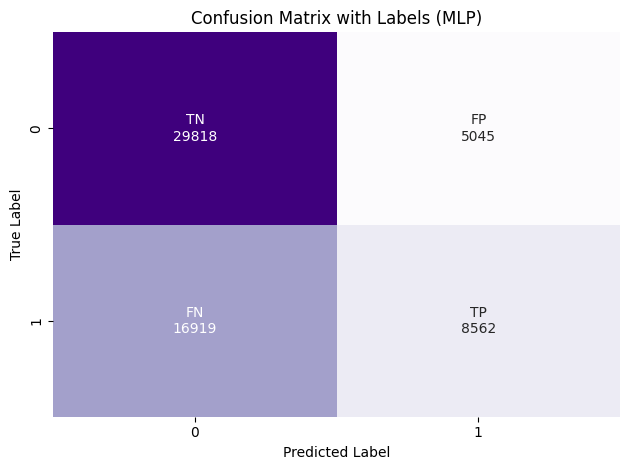

In [14]:
# Confusion Matrix

cm = confusion_matrix(y_test, preds_nn)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
sns.heatmap(cm, annot=labels + "\n" + cm.astype(str), fmt='', cmap='Purples', cbar=False)
plt.title("Confusion Matrix with Labels (MLP)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


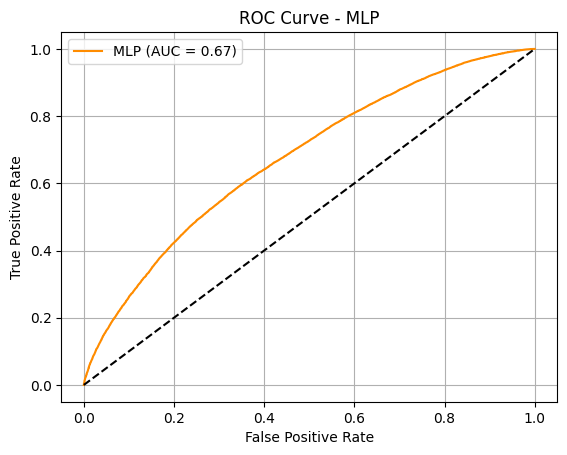

In [15]:
# ROC Curve

fpr, tpr, _ = roc_curve(y_test, probs_nn)
plt.plot(fpr, tpr, label=f"MLP (AUC = {auc(fpr, tpr):.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


Expected Calibration Error (ECE): 0.0231


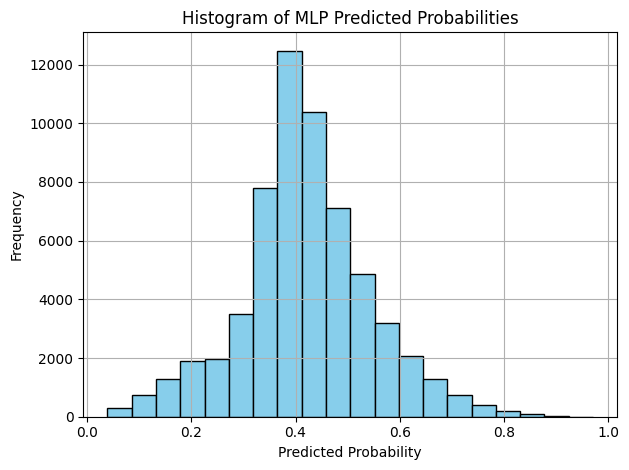

In [16]:
# Expected Calibration Error

def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0
    for i in range(n_bins):
        bin_mask = binids == i
        if bin_mask.any():
            bin_acc = y_true[bin_mask].mean()
            bin_conf = y_prob[bin_mask].mean()
            ece += np.abs(bin_acc - bin_conf) * bin_mask.mean()
    return ece

ece_val = expected_calibration_error(y_test.values, probs_nn)
print(f"Expected Calibration Error (ECE): {ece_val:.4f}")

plt.hist(probs_nn, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of MLP Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


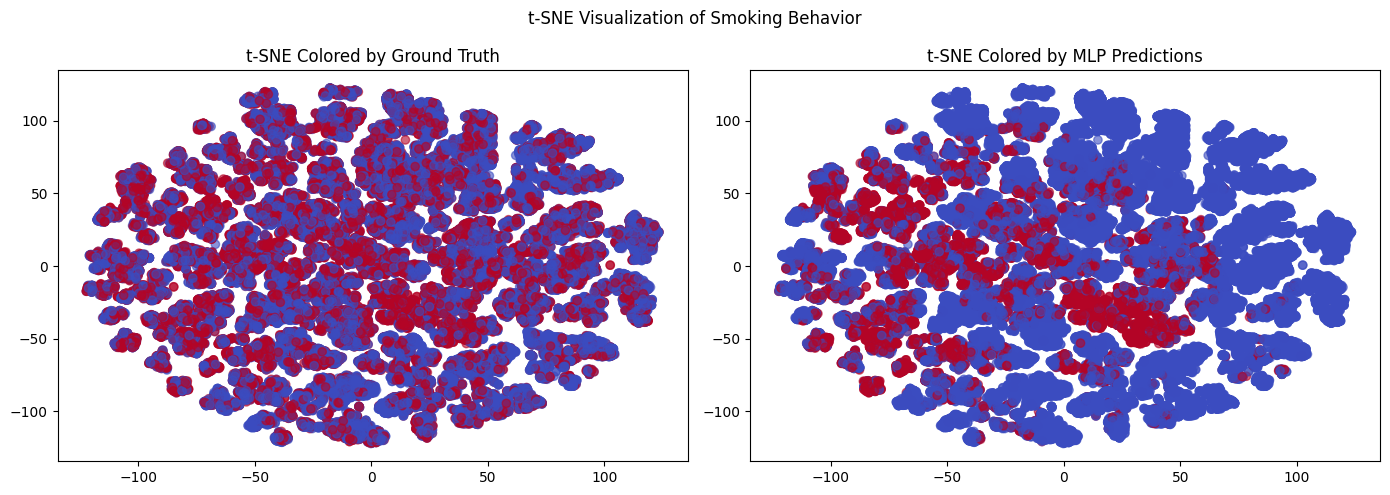

In [17]:
# t-SNE Visualization

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_test_scaled)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='coolwarm', alpha=0.6)
axs[0].set_title("t-SNE Colored by Ground Truth")
axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=preds_nn, cmap='coolwarm', alpha=0.6)
axs[1].set_title("t-SNE Colored by MLP Predictions")
plt.suptitle("t-SNE Visualization of Smoking Behavior")
plt.tight_layout()
plt.show()


In [ ]:
%%shell
jupyter nbconvert --to html /content/Snigdha_507Final.ipynb

[NbConvertApp] Converting notebook /content/Snigdha_507Final.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 1589899 bytes to /content/Snigdha_507Final.html
